<a href="https://colab.research.google.com/github/AkashKK25/pneumonia-xray-detection/blob/main/notebooks/pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection from Chest X-Rays
#### Author: Akash

## Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Step 2: Download and prepare the dataset

In [2]:
# Install Kaggle API
!pip install kaggle

# Upload your Kaggle API credentials
from google.colab import files
files.upload()  # Upload kaggle.json file

# Make the Kaggle directory
!mkdir -p ~/.kaggle

# Copy the kaggle.json file
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Step 3: Explore the dataset

Creating a better validation split...
Larger validation set created.
Training set: 1341 normal, 3875 pneumonia
Validation set: 276 normal, 783 pneumonia
Test set: 234 normal, 390 pneumonia


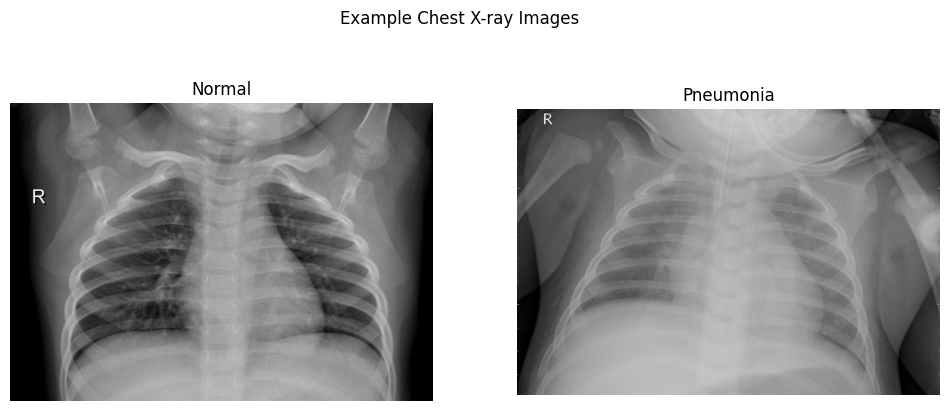

In [3]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Check if the val directory exists - if not, create it from train
if not os.path.exists(val_dir) or len(os.listdir(os.path.join(val_dir, 'NORMAL'))) < 20:
    print("Creating a better validation split...")

    # Create val directory if it doesn't exist
    os.makedirs(os.path.join(val_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'PNEUMONIA'), exist_ok=True)

    # Move 20% of training data to validation
    import random
    import shutil

    for cls in ['NORMAL', 'PNEUMONIA']:
        src_dir = os.path.join(train_dir, cls)
        files = os.listdir(src_dir)
        num_val = int(len(files) * 0.2)  # 20% for validation
        val_files = random.sample(files, num_val)

        for file in val_files:
            src_path = os.path.join(src_dir, file)
            dst_path = os.path.join(val_dir, cls, file)
            shutil.copy(src_path, dst_path)  # Copy instead of move to preserve original

    print("Larger validation set created.")

# Count the number of images in each split
def count_images(directory):
    normal_count = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal_count, pneumonia_count

train_normal, train_pneumonia = count_images(train_dir)
val_normal, val_pneumonia = count_images(val_dir)
test_normal, test_pneumonia = count_images(test_dir)

print(f"Training set: {train_normal} normal, {train_pneumonia} pneumonia")
print(f"Validation set: {val_normal} normal, {val_pneumonia} pneumonia")
print(f"Test set: {test_normal} normal, {test_pneumonia} pneumonia")

# Visualize some example images
plt.figure(figsize=(12, 5))

# Normal example
normal_img_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
normal_img = Image.open(normal_img_path)
plt.subplot(1, 2, 1)
plt.imshow(normal_img, cmap='gray')
plt.title('Normal')
plt.axis('off')

# Pneumonia example
pneumonia_img_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0])
pneumonia_img = Image.open(pneumonia_img_path)
plt.subplot(1, 2, 2)
plt.imshow(pneumonia_img, cmap='gray')
plt.title('Pneumonia')
plt.axis('off')

plt.suptitle('Example Chest X-ray Images')
plt.show()

# Step 4: Data Preprocessing and Augmentation

In [4]:
IMG_SIZE = 224  # MobileNetV2 input size

# Enhanced Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # Increased from 10
    width_shift_range=0.2,     # Increased from 0.1
    height_shift_range=0.2,    # Increased from 0.1
    shear_range=0.15,          # Increased from 0.1
    zoom_range=0.15,           # Increased from 0.1
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Add brightness variation
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 1059 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class distribution
train_normal, train_pneumonia = count_images(train_dir)
total_samples = train_normal + train_pneumonia
weight_for_0 = (1 / train_normal) * (total_samples / 2)
weight_for_1 = (1 / train_pneumonia) * (total_samples / 2)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Class weights: {class_weight}")

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


# Step 5: Create the Model using Transfer Learning

In [6]:
# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)  # Increased from 0.2
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 6: Train the model

In [7]:
# Set up callbacks for better training
checkpoint = ModelCheckpoint(
    'pneumonia_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.7891 - loss: 0.6874
Epoch 1: val_accuracy improved from -inf to 0.92140, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 762ms/step - accuracy: 0.7895 - loss: 0.6867 - val_accuracy: 0.9214 - val_loss: 0.4321 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9042 - loss: 0.4235
Epoch 2: val_accuracy did not improve from 0.92140
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 810ms/step - accuracy: 0.9042 - loss: 0.4234 - val_accuracy: 0.9034 - val_loss: 0.4161 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9111 - loss: 0.3840
Epoch 3: val_accuracy did not improve from 0.92140
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 694ms/step - accuracy: 0.9111 - loss: 0.3839 - val_accuracy: 0.9186 - val_loss: 0.3715 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9197 - loss: 0.3594
Epoch 4: val_accuracy did not improve from 0.92140
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 687ms/step - accuracy: 0.9197 - loss: 0.3593 - val_accuracy: 0.9081 - val_loss: 0.3705 - learning_rate

163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 691ms/step - accuracy: 0.9305 - loss: 0.3331 - val_accuracy: 0.9261 - val_loss: 0.3260 - learning_rate: 1.0000e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9263 - loss: 0.3241
Epoch 6: val_accuracy did not improve from 0.92614
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 686ms/step - accuracy: 0.9263 - loss: 0.3240 - val_accuracy: 0.9195 - val_loss: 0.3287 - learning_rate: 1.0000e-04
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9380 - loss: 0.3011
Epoch 7: val_accuracy did not improve from 0.92614
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 695ms/step - accuracy: 0.9380 - loss: 0.3011 - val_accuracy: 0.9195 - val_loss: 0.3255 - learning_rate: 1.0000e-04
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9467 - loss: 0.2802
Epoch 8: val_accuracy improved from 0.92614 to 0.93277, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 696ms/step - accuracy: 0.9467 - loss: 0.2802 - val_accuracy: 0.9328 - val_loss: 0.2912 - learning_rate: 1.0000e-04
Epoch 9/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9390 - loss: 0.2865
Epoch 9: val_accuracy did not improve from 0.93277
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 696ms/step - accuracy: 0.9390 - loss: 0.2864 - val_accuracy: 0.9233 - val_loss: 0.3007 - learning_rate: 1.0000e-04
Epoch 10/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.9384 - loss: 0.2754
Epoch 10: val_accuracy did not improve from 0.93277
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 709ms/step - accuracy: 0.9385 - loss: 0.2754 - val_accuracy: 0.9290 - val_loss: 0.2984 - learning_rate: 1.0000e-04
Epoch 11/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9440 - loss: 0.2569
Epoch 11: val_accuracy did not improve from 0.93277
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 692ms/step - accuracy: 0.9440 - loss: 0.2569 - val_accuracy: 0.9290 - val_loss: 0.2798 - learning_

163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 692ms/step - accuracy: 0.9476 - loss: 0.2484 - val_accuracy: 0.9394 - val_loss: 0.2662 - learning_rate: 1.0000e-04
Epoch 13/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9394 - loss: 0.2534
Epoch 13: val_accuracy did not improve from 0.93939
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 701ms/step - accuracy: 0.9394 - loss: 0.2534 - val_accuracy: 0.9384 - val_loss: 0.2627 - learning_rate: 1.0000e-04
Epoch 14/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9485 - loss: 0.2358
Epoch 14: val_accuracy did not improve from 0.93939
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 680ms/step - accuracy: 0.9485 - loss: 0.2359 - val_accuracy: 0.9205 - val_loss: 0.3019 - learning_rate: 1.0000e-04
Epoch 15/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9482 - loss: 0.2399
Epoch 15: val_accuracy did not improve from 0.93939
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 696ms/step - accuracy: 0.9482 - loss: 0.2400 - val_accuracy: 0.9233 - val_loss: 0.2870 - learnin

# Step 7: Train the top layers, then fine-tune a few convolutional layers

In [8]:
# First train only the top layers
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight  # Add class weights
)

# Unfreeze just a few layers at a time
for layer in base_model.layers[-10:]:  # Unfreeze fewer layers (only last 10 instead of 20)
    layer.trainable = True

# Freeze the rest
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile with a MUCH lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.000005),  # Even lower learning rate (5e-6 instead of 1e-5)
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks with more patience
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,              # Increased from 5
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,              # More gentle reduction (0.2 instead of 0.5)
    patience=5,              # Increased from 3
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Fine-tune with smaller batch size
batch_size = 16  # Reduced from 32
train_generator.batch_size = batch_size
validation_generator.batch_size = batch_size
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Train with fine-tuning
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,               # Increased from 10
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight  # Add class weights
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9312 - loss: 0.2755
Epoch 1: val_accuracy did not improve from 0.93939
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 686ms/step - accuracy: 0.9312 - loss: 0.2755 - val_accuracy: 0.9252 - val_loss: 0.2974 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.9334 - loss: 0.2614
Epoch 2: val_accuracy did not improve from 0.93939
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 677ms/step - accuracy: 0.9334 - loss: 0.2614 - val_accuracy: 0.9129 - val_loss: 0.3307 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9397 - loss: 0.2467
Epoch 3: val_accuracy did not improve from 0.93939
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 678ms/step - accuracy: 0.9397 - loss: 0.2467 - val_accuracy: 0.8873 - val_loss: 0.3702 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9285 - loss: 0.2639
Epoch 4: val_accuracy did not improve from 0.939


Epoch 10: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
326/326 ━━━━━━━━━━━━━━━━━━━━ 112s 343ms/step - accuracy: 0.9391 - loss: 0.2595 - val_accuracy: 0.9403 - val_loss: 0.2847 - learning_rate: 5.0000e-06
Epoch 11/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9398 - loss: 0.2565
Epoch 11: val_accuracy did not improve from 0.94034
326/326 ━━━━━━━━━━━━━━━━━━━━ 141s 340ms/step - accuracy: 0.9397 - loss: 0.2565 - val_accuracy: 0.9252 - val_loss: 0.3106 - learning_rate: 1.0000e-06
Epoch 12/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9382 - loss: 0.2627
Epoch 12: val_accuracy did not improve from 0.94034
326/326 ━━━━━━━━━━━━━━━━━━━━ 142s 340ms/step - accuracy: 0.9382 - loss: 0.2627 - val_accuracy: 0.9214 - val_loss: 0.3276 - learning_rate: 1.0000e-06
Epoch 13/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9377 - loss: 0.2650
Epoch 13: val_accuracy did not improve from 0.94034
326/326 ━━━━━━━━━━━━━━━━━━━━ 111s 341ms/step - accur

# Step 8: Evaluate the model

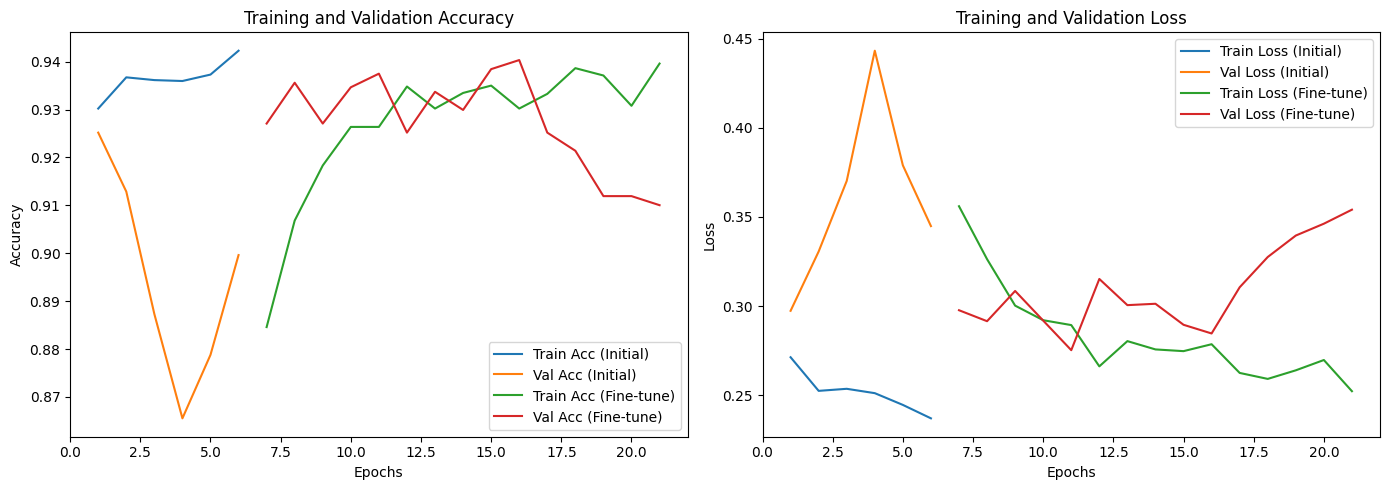

In [9]:
# Combine the history objects
total_epochs = len(history.history['accuracy']) + len(history_fine_tune.history['accuracy'])
epochs_range = range(1, total_epochs + 1)

plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(
    epochs_range[:len(history.history['accuracy'])],
    history.history['accuracy'],
    label='Train Acc (Initial)'
)
plt.plot(
    epochs_range[:len(history.history['val_accuracy'])],
    history.history['val_accuracy'],
    label='Val Acc (Initial)'
)
plt.plot(
    epochs_range[len(history.history['accuracy']):],
    history_fine_tune.history['accuracy'],
    label='Train Acc (Fine-tune)'
)
plt.plot(
    epochs_range[len(history.history['val_accuracy']):],
    history_fine_tune.history['val_accuracy'],
    label='Val Acc (Fine-tune)'
)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(
    epochs_range[:len(history.history['loss'])],
    history.history['loss'],
    label='Train Loss (Initial)'
)
plt.plot(
    epochs_range[:len(history.history['val_loss'])],
    history.history['val_loss'],
    label='Val Loss (Initial)'
)
plt.plot(
    epochs_range[len(history.history['loss']):],
    history_fine_tune.history['loss'],
    label='Train Loss (Fine-tune)'
)
plt.plot(
    epochs_range[len(history.history['val_loss']):],
    history_fine_tune.history['val_loss'],
    label='Val Loss (Fine-tune)'
)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 9: Test set evaluation

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.8515 - loss: 0.4595
Test Accuracy: 0.8990
Test Loss: 0.3617
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step


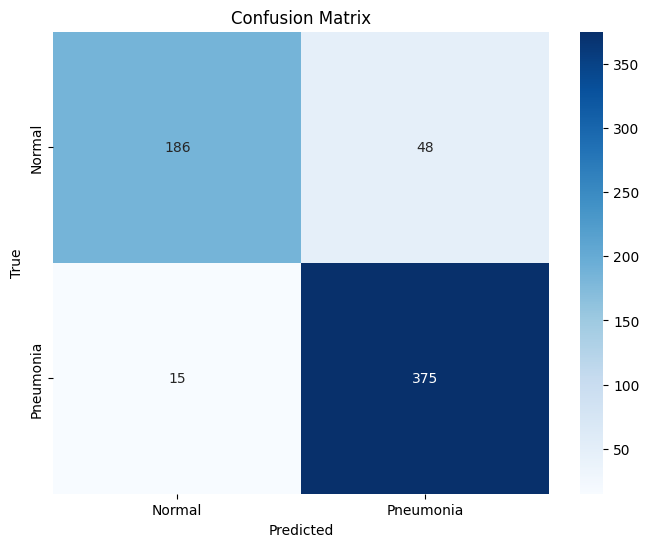

              precision    recall  f1-score   support

      Normal       0.93      0.79      0.86       234
   Pneumonia       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



In [10]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions for test data
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = ['Normal', 'Pneumonia']
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Step 10: Save the model for deployment

In [11]:
model.save('pneumonia_model_final.h5')

# Convert to TensorFlow Lite for deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model
with open('pneumonia_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite format for deployment.")

Saved artifact at '/tmp/tmpmnnz1otr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136775961227152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136773171944272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136773171944656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775961227536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136773172595408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775961227920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136773171943888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136773171943120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136773171945040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136773171944848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13677317194542

# Step 11: Visualize model predictions on test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


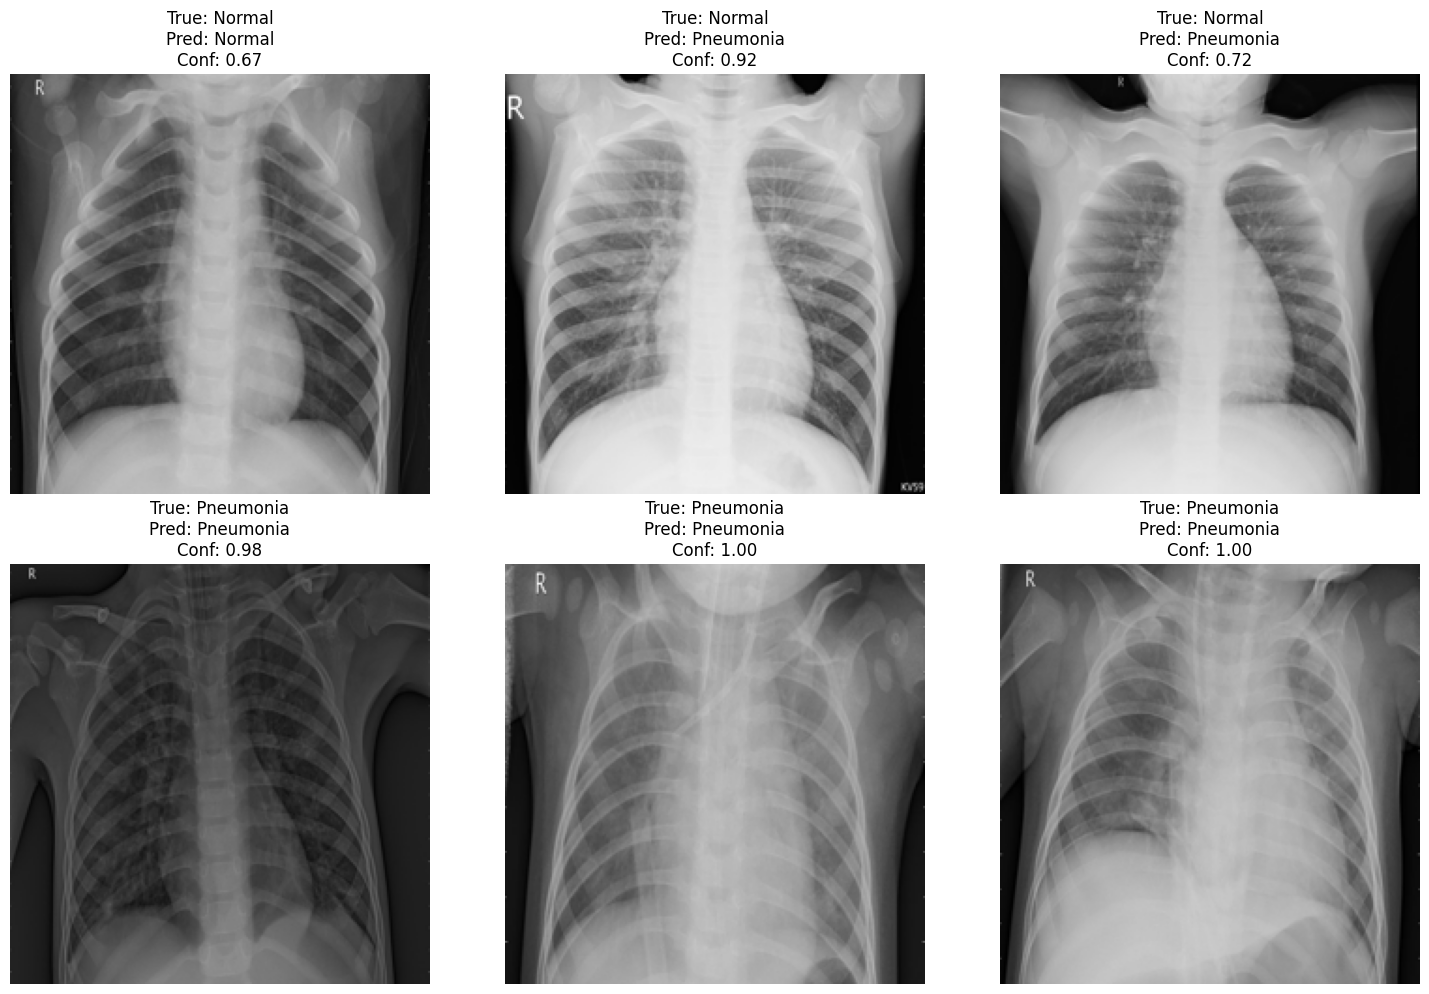

In [12]:
def display_predictions(model, test_dir, num_samples=6):
    # Get random images from test set
    normal_files = os.listdir(os.path.join(test_dir, 'NORMAL'))
    pneumonia_files = os.listdir(os.path.join(test_dir, 'PNEUMONIA'))

    # Randomly select images from each class
    normal_samples = np.random.choice(normal_files, min(num_samples//2, len(normal_files)), replace=False)
    pneumonia_samples = np.random.choice(pneumonia_files, min(num_samples//2, len(pneumonia_files)), replace=False)

    plt.figure(figsize=(15, 10))
    count = 1

    # Process normal images
    for sample in normal_samples:
        img_path = os.path.join(test_dir, 'NORMAL', sample)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        predicted_class = "Pneumonia" if prediction > 0.5 else "Normal"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.subplot(2, num_samples//2, count)
        plt.imshow(img)
        plt.title(f"True: Normal\nPred: {predicted_class}\nConf: {confidence:.2f}")
        plt.axis('off')
        count += 1

    # Process pneumonia images
    for sample in pneumonia_samples:
        img_path = os.path.join(test_dir, 'PNEUMONIA', sample)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        predicted_class = "Pneumonia" if prediction > 0.5 else "Normal"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.subplot(2, num_samples//2, count)
        plt.imshow(img)
        plt.title(f"True: Pneumonia\nPred: {predicted_class}\nConf: {confidence:.2f}")
        plt.axis('off')
        count += 1

    plt.tight_layout()
    plt.show()

# Display model predictions on sample test images
display_predictions(model, test_dir)

# Step 12: Download the models

In [13]:
from google.colab import files
files.download('pneumonia_model_final.h5')
files.download('pneumonia_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>